# Belen Experiments Various

In [1]:
import sys
sys.path.insert(0, '../../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle

from qiskit.quantum_info import DensityMatrix, random_unitary, random_clifford
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm

from loss_functions import *
from optimization import *
from quantum_channel import *
from kraus_channels import *
from quantum_tools import *
from experimental import *
from spam import *
from quantum_circuits import *

#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import random_unitary, Operator
from qiskit.providers.fake_provider import FakeManilaV2

from qiskit import Aer

In [3]:
#qk.IBMQ.save_account("aaff224a30e77d3ea3af33e2e3fb1cebfbff4e33b04ef75fdbbb9e9055426f547739b68d5b93dac4d47e7828d840a212436b1c36a358f9185574ce60af9a9f53", overwrite=True) 
provider = qk.IBMQ.load_account()
provider = qk.IBMQ.get_provider(hub='ibm-q', group='open', project='main')

In [4]:
from qiskit.converters import circuit_to_dag, dag_to_circuit
from collections import OrderedDict

def remove_idle_qwires(circ):
    dag = circuit_to_dag(circ)

    idle_wires = list(dag.idle_wires())
    for w in idle_wires:
        dag._remove_idle_wire(w)
        dag.qubits.remove(w)

    dag.qregs = OrderedDict()

    return dag_to_circuit(dag)

## Non-integrable

In [8]:
backend = provider.get_backend("ibm_nairobi")

circuit_sqrt_iswap = qk.QuantumCircuit(2)
circuit_sqrt_iswap.append(iSwapGate().power(1 / 2), [0, 1])

circuit_sqrt_x = qk.QuantumCircuit(1)
circuit_sqrt_x.append(XGate().power(1 / 2), [0])

circuit_sqrt_y = qk.QuantumCircuit(1)
circuit_sqrt_y.append(YGate().power(1 / 2), [0])

circuit_sqrt_v = qk.QuantumCircuit(1)
circuit_sqrt_v.append(RGate(np.pi / 2, np.pi / 4), [0])

circuit_sqrt_w = qk.QuantumCircuit(1)
circuit_sqrt_w.append(RGate(np.pi / 2, -np.pi / 4), [0])

circuit_rz = qk.QuantumCircuit(1)
circuit_rz.append(RZGate(np.random.uniform(-np.pi, np.pi)), [0])

print(circuit_sqrt_iswap)
print(circuit_sqrt_x)
print(circuit_sqrt_y)
print(circuit_sqrt_v)
print(circuit_sqrt_w)
print(circuit_rz)


     ┌────────────┐
q_0: ┤0           ├
     │  iswap^0.5 │
q_1: ┤1           ├
     └────────────┘
   ┌───────┐
q: ┤ x^0.5 ├
   └───────┘
   ┌───────┐
q: ┤ y^0.5 ├
   └───────┘
   ┌────────────┐
q: ┤ R(π/2,π/4) ├
   └────────────┘
   ┌─────────────┐
q: ┤ R(π/2,-π/4) ├
   └─────────────┘
   ┌─────────────┐
q: ┤ Rz(0.31071) ├
   └─────────────┘


In [21]:
transpiled_sqrt_iswap = qk.transpile(circuit_sqrt_iswap, backend=backend, optimization_level=0, seed_transpiler=42)
transpiled_sqrt_x = qk.transpile(circuit_sqrt_x, backend=backend, optimization_level=0, seed_transpiler=42)
transpiled_sqrt_y = qk.transpile(circuit_sqrt_y, backend=backend, optimization_level=0, seed_transpiler=42)
transpiled_sqrt_v = qk.transpile(circuit_sqrt_v, backend=backend, optimization_level=0, seed_transpiler=42)
transpiled_sqrt_w = qk.transpile(circuit_sqrt_w, backend=backend, optimization_level=0, seed_transpiler=42)
transpiled_rz = qk.transpile(circuit_rz, backend=backend, optimization_level=0, seed_transpiler=42)

transpiled_sqrt_iswap = remove_idle_qwires(transpiled_sqrt_iswap)
transpiled_sqrt_x = remove_idle_qwires(transpiled_sqrt_x)
transpiled_sqrt_y = remove_idle_qwires(transpiled_sqrt_y)
transpiled_sqrt_v = remove_idle_qwires(transpiled_sqrt_v)
transpiled_sqrt_w = remove_idle_qwires(transpiled_sqrt_w)
transpiled_rz = remove_idle_qwires(transpiled_rz)

In [22]:
print(transpiled_sqrt_iswap)
print("-------------------")
print(transpiled_sqrt_x)
print("-------------------")
print(transpiled_sqrt_y)
print("-------------------")
print(transpiled_sqrt_v)
print("-------------------")
print(transpiled_sqrt_w)
print("-------------------")
print(transpiled_rz)

global phase: 2π
    ┌─────────┐ ┌────┐┌──────────┐        ┌────┐  ┌──────────┐┌────┐     »
0: ─┤ Rz(π/4) ├─┤ √X ├┤ Rz(-π/2) ├──■─────┤ √X ├──┤ Rz(-π/4) ├┤ √X ├──■──»
   ┌┴─────────┴┐├────┤└──────────┘┌─┴─┐┌──┴────┴─┐└──────────┘└────┘┌─┴─┐»
1: ┤ Rz(-3π/4) ├┤ √X ├────────────┤ X ├┤ Rz(π/4) ├──────────────────┤ X ├»
   └───────────┘└────┘            └───┘└─────────┘                  └───┘»
«   ┌──────────┐   ┌────┐   ┌──────────┐
«0: ┤ Rz(-π/2) ├───┤ √X ├───┤ Rz(-π/4) ├
«   └──┬────┬──┘┌──┴────┴──┐└──────────┘
«1: ───┤ √X ├───┤ Rz(3π/4) ├────────────
«      └────┘   └──────────┘            
-------------------
   ┌────┐
0: ┤ √X ├
   └────┘
-------------------
   ┌──────────┐┌────┐┌─────────┐
0: ┤ Rz(-π/2) ├┤ √X ├┤ Rz(π/2) ├
   └──────────┘└────┘└─────────┘
-------------------
global phase: 3π/2
   ┌─────────┐┌────┐┌──────────┐┌────┐┌───────────┐
0: ┤ Rz(π/4) ├┤ √X ├┤ Rz(3π/2) ├┤ √X ├┤ Rz(11π/4) ├
   └─────────┘└────┘└──────────┘└────┘└───────────┘
-------------------
global phase: 3π/2


## Compiling QFT

In [5]:
from qiskit.circuit.library import QFT
#four quibt quantum fourier transform circuit with qiskit
qft = QFT(4, do_swaps=True, inverse=False)

backend = provider.get_backend("ibmq_manila")

transpiled_qft0 = qk.transpile(qft, backend=backend, optimization_level=0, seed_transpiler=42)
transpiled_qft0 = remove_idle_qwires(transpiled_qft0)

cx_count = 0
for gate in transpiled_qft0:
    if gate.operation.name == "cx":
        cx_count += 1

print(cx_count)

33


In [6]:
print(transpiled_qft0)

global phase: 4.8106
                                                                           »
0: ────────────────────────────────────────────────────────────────────────»
                                                                           »
1: ────────────────────────────────────────────────────────────────────────»
                                          ┌───┐┌──────────┐┌───┐┌─────────┐»
2: ───────────────────────────────────────┤ X ├┤ Rz(-π/4) ├┤ X ├┤ Rz(π/4) ├»
   ┌─────────┐┌────┐┌─────────┐┌─────────┐└─┬─┘└──────────┘└─┬─┘├─────────┤»
3: ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/4) ├──■────────────────■──┤ Rz(π/8) ├»
   └─────────┘└────┘└─────────┘└─────────┘                      └─────────┘»
«                                                                ┌───┐     »
«0: ──────────────────────────────────────────────────────■──────┤ X ├──■──»
«        ┌───┐     ┌─────────┐   ┌────┐   ┌─────────┐   ┌─┴─┐    └─┬─┘┌─┴─┐»
«1: ──■──┤ X ├──■──┤ Rz(π/2) ├───┤ √X ├───┤ Rz(π/2) ├──

In [45]:
transpiled_qft1 = qk.transpile(qft, backend=backend, optimization_level=1, seed_transpiler=42)
transpiled_qft1 = remove_idle_qwires(transpiled_qft1)

cx_count = 0
for gate in transpiled_qft1:
    if gate.operation.name == "cx":
        cx_count += 1

print(cx_count)

39


In [46]:
transpiled_qft2 = qk.transpile(qft, backend=backend, optimization_level=2, seed_transpiler=42)
transpiled_qft2 = remove_idle_qwires(transpiled_qft2)

cx_count = 0
for gate in transpiled_qft2:
    if gate.operation.name == "cx":
        cx_count += 1

print(cx_count)

39


In [47]:
transpiled_qft3 = qk.transpile(qft, backend=backend, optimization_level=3, seed_transpiler=42)
transpiled_qft3 = remove_idle_qwires(transpiled_qft3)

cx_count = 0
for gate in transpiled_qft3:
    if gate.operation.name == "cx":
        cx_count += 1

print(cx_count)

19


In [35]:
cx_count = 0

for gate in transpiled_qft3:
    if gate.operation.name == "cx":
        cx_count += 1

print(cx_count)

19


c:\Users\krist\anaconda3\envs\env_qiskit\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


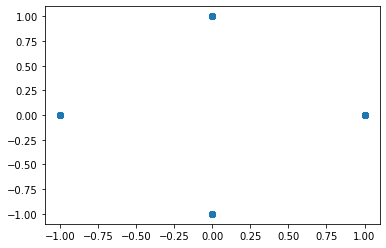

In [50]:
U = circuit_to_matrix(qft)

channel_U = ChoiMapStatic(U, mode="unitary")
spectrum = channel_spectrum(channel_U)

plt.plot(spectrum[:,0], spectrum[:,1], "o")
plt.show()

c:\Users\krist\anaconda3\envs\env_qiskit\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


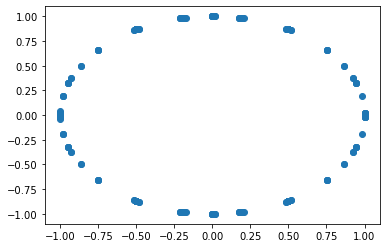

In [55]:
U_trans = Operator(transpiled_qft3).data

channel_U = ChoiMapStatic(U_trans, mode="unitary")
spectrum = channel_spectrum(channel_U)

plt.plot(spectrum[:,0], spectrum[:,1], "o")
plt.show()